In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")
import data_prep

In [3]:
#Figure formattings
font = {'family' : 'serif',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('lines', linewidth=3)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)

In [5]:
machine_name = 'Theta'

In [7]:
X_train, y_train, X_test, y_test, X_eval, y_eval, y_train_log, y_eval_log, y_test_log, y_train_without_outliers, X_train_without_outliers, X_train_reduced, X_test_reduced, X_eval_reduced, X_train_class, y_train_class,X_test_class,y_test_class, X_eval_class, y_eval_class, X_train_class_reduced, y_train_class_reduced, X_test_class_reduced, y_test_class_reduced, X_eval_class_reduced, y_eval_class_reduced = data_prep.load_parse_final_data(machine_name)
print(X_train_reduced.shape)
print(X_eval_reduced.shape)
print(X_test_reduced.shape)

print(y_train_log.shape)
print(y_train_without_outliers.shape) 


(286324, 1)
(281133, 17)
(95442, 17)
(95442, 17)
(286324, 1)
(281133, 1)


In [ ]:
#model training, evaluation and testing is done using:
#1. Data to which outlier removal and PCA had been applied (X_train_reduced, X_eval_reduced, X_test_reduced)
#2. Data without outlier removal and PCA (X_train, X_eval, X_test)

# Hyperparameter tunning

In [10]:
# Tune hyperparameter with random search
# Number of trees in random forest
n_estimators = [100,200,300,400,500]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 5, 7, 10,15,20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2,3, 4,6,10,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth':max_depth,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['log2', 'sqrt'], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [2, 3, 4, 6, 10, 15], 'max_depth': [2, 5, 7, 10, 15, 20], 'bootstrap': [True, False]}


In [12]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, random_state=42)
rf_random.fit(X_train, y_train_log)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time= 1.9min
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time= 1.9min
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time= 2.0min
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time= 1.9min
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time= 2.0min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 1.4min
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 10, 15, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 6, 10,
                                                             15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [13]:
print(rf_random.best_params_)

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [14]:
#Train with hyperparameters from random search, try various max_depth/tree_depth values
best_params = rf_random.best_params_
if 'max_depth' in best_params:
    del best_params['max_depth']
# List of tree_depth values to test
max_depth = [10, 20, 50, 100, 200,300,500]

# Containers to store results
rf_train_times = []
rf_predict_times = []
rf_r2_scores_eval = []
rf_rmse_eval = []
rf_mae_eval = []
rf_mape_eval = []

# Loop through each max_depth value
for depth in max_depth:
    print(f"\nTraining RandomForestRegressor with tree_depth = {depth}")
    best_params['max_depth'] = depth
    rf = RandomForestRegressor(**best_params)

    # Training
    start_train = time.time()
    rf.fit(X_train, y_train_log) #target was log transformed (np.log(y+1)) to reduce skewness
    end_train = time.time()
    train_duration = end_train - start_train
    # Print time taken to train model
    rf_train_times.append(train_duration)
    print(f"Training time: {train_duration:.2f} seconds")
    # Prediction on evaluation set
    start_test = time.time()
    y_pred_log = rf.predict(X_eval)
    end_test = time.time()
    predict_duration = end_test - start_test
    rf_predict_times.append(predict_duration)
    # Print prediction time
    print(f"Prediction time: {predict_duration:.2f} seconds")

    # Evaluate on evaluation data
    y_pred = np.expm1(y_pred_log)
    r2_eval = r2_score(y_eval,y_pred)
    rmse_eval = np.sqrt(mean_squared_error(y_eval, y_pred))
    mae_eval = mean_absolute_error(y_eval, y_pred)
    mape_eval = mean_absolute_percentage_error(y_eval, y_pred)
    
    rf_r2_scores_eval.append(r2_eval)
    rf_rmse_eval.append(rmse_eval)
    rf_mae_eval.append(mae_eval)
    rf_mape_eval.append(mape_eval)
    print(f"  R2 Score: {r2_eval:.2f}")
    print(f"  RMSE: {rmse_eval:.2f}")
    print(f"  MAE: {mae_eval:.2f}")
    print(f"  MAPE: {mape_eval:.2f}")
   


Training RandomForestRegressor with tree_depth = 10
Training time: 59.99 seconds
Prediction time: 1.52 seconds
  R2 Score: 0.31
  RMSE: 28.07
  MAE: 5.17
  MAPE: 17.29

Training RandomForestRegressor with tree_depth = 20
Training time: 104.49 seconds
Prediction time: 4.23 seconds
  R2 Score: 0.61
  RMSE: 21.16
  MAE: 3.68
  MAPE: 10.70

Training RandomForestRegressor with tree_depth = 50
Training time: 1072.53 seconds
Prediction time: 5.58 seconds
  R2 Score: 0.62
  RMSE: 20.98
  MAE: 3.55
  MAPE: 10.08

Training RandomForestRegressor with tree_depth = 100
Training time: 1022.64 seconds
Prediction time: 5.68 seconds
  R2 Score: 0.62
  RMSE: 20.96
  MAE: 3.54
  MAPE: 10.05

Training RandomForestRegressor with tree_depth = 200
Training time: 657.47 seconds
Prediction time: 5.47 seconds
  R2 Score: 0.62
  RMSE: 20.98
  MAE: 3.54
  MAPE: 10.03

Training RandomForestRegressor with tree_depth = 300
Training time: 118.48 seconds
Prediction time: 5.58 seconds
  R2 Score: 0.62
  RMSE: 20.98
  

In [20]:
# Select best max_depth based on r2 score on evaluation data
best_depth_index = np.argmax(rf_r2_scores_eval)
optimal_depth = max_depth[best_depth_index]
print(f"\nBest max_depth based on evaluation data: {optimal_depth}")

# Final model training with best depth
print("\nRetraining on full training data with best max_depth and evaluating on test data...")
best_params['max_depth'] = optimal_depth
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train_log)

# Test prediction
y_test_pred_log = final_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

# Test performance
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nFinal Test Set Performance:")
print(f"  R2 Score: {r2_test:.2f}")
print(f"  RMSE: {rmse_test:.2f}")
print(f"  MAE: {mae_test:.2f}")
print(f"  MAPE: {mape_test:.2f}")


Best max_depth based on evaluation data: 100

Retraining on full training data with best max_depth and evaluating on test data...

Final Test Set Performance:
  R2 Score: 0.54
  RMSE: 27.40
  MAE: 3.70
  MAPE: 10.38


# XGBOOST

In [22]:
from xgboost import XGBRegressor
# Define the hyperparameter grid for randomized search
random_grid = {
    'n_estimators': [100, 200, 300, 400, 500,1000],
    'learning_rate': [0.01, 0.02, 0.001],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [2, 5, 7, 10,15,20],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1, 10],
     
}

print("Random Search Hyperparameter Grid for XGB:")
print(random_grid)

Random Search Hyperparameter Grid for XGB:
{'n_estimators': [100, 200, 300, 400, 500, 1000], 'learning_rate': [0.01, 0.02, 0.001], 'min_child_weight': [1, 3, 5, 7, 10], 'subsample': [0.6, 0.8, 1.0], 'max_depth': [2, 5, 7, 10, 15, 20], 'colsample_bytree': [0.6, 0.8, 1.0], 'gamma': [0, 0.1, 0.2, 0.5], 'reg_alpha': [0, 0.1, 1], 'reg_lambda': [0.1, 1, 10]}


In [23]:
# Instantiate the model
xgb = XGBRegressor()
# Perform randomized search with 5-fold cross-validation
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=random_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
xgb_random.fit(X_train, y_train_log)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.02, max_depth=15, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.6; total time=  21.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=400, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.02, 0.001],
                                        'max_depth': [2, 5, 7, 10, 15, 20],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 1000],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0.1, 1, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [24]:
print(xgb_random.best_params_)

{'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 15, 'learning_rate': 0.02, 'gamma': 0, 'colsample_bytree': 0.8}


In [56]:
#Train with hyperparameters from random search, with different tree depths
if 'max_depth' in best_params:
    del best_params['max_depth']
# List of max_depth values to test
max_depth_values = [10, 20, 50, 100, 200, 300, 500]

# Containers to store results
xgb_train_times = []
xgb_predict_times = []
xgb_r2_scores_eval = []
xgb_rmse_eval = []
xgb_mae_eval = []
xgb_mape_eval = []

# Loop through each max_depth value
for depth in max_depth_values:
    print(f"\nTraining RandomForestRegressor with max_depth = {depth}")
    best_params['max_depth'] = depth
    xgb = XGBRegressor(**best_params)

    # Training
    start_train = time.time()
    xgb.fit(X_train, y_train_log)
    end_train = time.time()
    train_duration = end_train - start_train
    # Print time taken to train model
    xgb_train_times.append(train_duration)
    print(f"Training time: {train_duration:.2f} seconds")

    # Prediction on evaluation set
    start_test = time.time()
    y_pred_log = xgb.predict(X_eval)
    end_test = time.time()
    predict_duration = end_test - start_test
    xgb_predict_times.append(predict_duration)
    # Print prediction time
    print(f"Prediction time: {predict_duration:.2f} seconds")
    
    # Evaluate on evaluation data
    y_pred = np.expm1(y_pred_log)
    r2_eval = r2_score(y_eval, y_pred)
    rmse_eval = np.sqrt(mean_squared_error(y_eval, y_pred))
    mae_eval = mean_absolute_error(y_eval, y_pred)
    mape_eval = mean_absolute_percentage_error(y_eval, y_pred)

    xgb_r2_scores_eval.append(r2_eval)
    xgb_rmse_eval.append(rmse_eval)
    xgb_mae_eval.append(mae_eval)
    xgb_mape_eval.append(mape_eval)
    print(f"  R2 Score: {r2_eval:.2f}")
    print(f"  RMSE: {rmse_eval:.2f}")
    print(f"  MAE: {mae_eval:.2f}")
    print(f"  MAPE: {mape_eval:.2f}")


Training RandomForestRegressor with max_depth = 10
Training time: 3.27 seconds
Prediction time: 0.10 seconds
  R2 Score: 0.69
  RMSE: 19.03
  MAE: 3.21
  MAPE: 10.46

Training RandomForestRegressor with max_depth = 20
Training time: 15.10 seconds
Prediction time: 0.31 seconds
  R2 Score: 0.70
  RMSE: 18.72
  MAE: 3.00
  MAPE: 9.91

Training RandomForestRegressor with max_depth = 50
Training time: 18.95 seconds
Prediction time: 0.38 seconds
  R2 Score: 0.70
  RMSE: 18.70
  MAE: 3.02
  MAPE: 10.16

Training RandomForestRegressor with max_depth = 100
Training time: 17.38 seconds
Prediction time: 0.36 seconds
  R2 Score: 0.70
  RMSE: 18.70
  MAE: 3.02
  MAPE: 10.15

Training RandomForestRegressor with max_depth = 200
Training time: 18.54 seconds
Prediction time: 0.35 seconds
  R2 Score: 0.70
  RMSE: 18.70
  MAE: 3.02
  MAPE: 10.15

Training RandomForestRegressor with max_depth = 300
Training time: 17.93 seconds
Prediction time: 0.35 seconds
  R2 Score: 0.70
  RMSE: 18.70
  MAE: 3.02
  MAP

In [57]:
# Select best max_depth based on r2 score on evaluation data
best_depth_index = np.argmax(xgb_r2_scores_eval)
optimal_depth = max_depth[best_depth_index]
print(f"\nBest max_depth based on evaluation data: {optimal_depth}")

# Final model training with best depth
print("\nRetraining on full training data with best max_depth and evaluating on test data...")
best_params['max_depth'] = optimal_depth
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train_log)

# Test prediction
y_test_pred_log = final_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

# Test performance
xgb_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nFinal Test Set Performance:")
print(f"  R2 Score: {r2_test:.2f}")
print(f"  RMSE: {rmse_test:.2f}")
print(f"  MAE: {mae_test:.2f}")
print(f"  MAPE: {mape_test:.2f}")


Best max_depth based on evaluation data: 100

Retraining on full training data with best max_depth and evaluating on test data...

Final Test Set Performance:
  R2 Score: 0.54
  RMSE: 25.40
  MAE: 3.16
  MAPE: 10.06


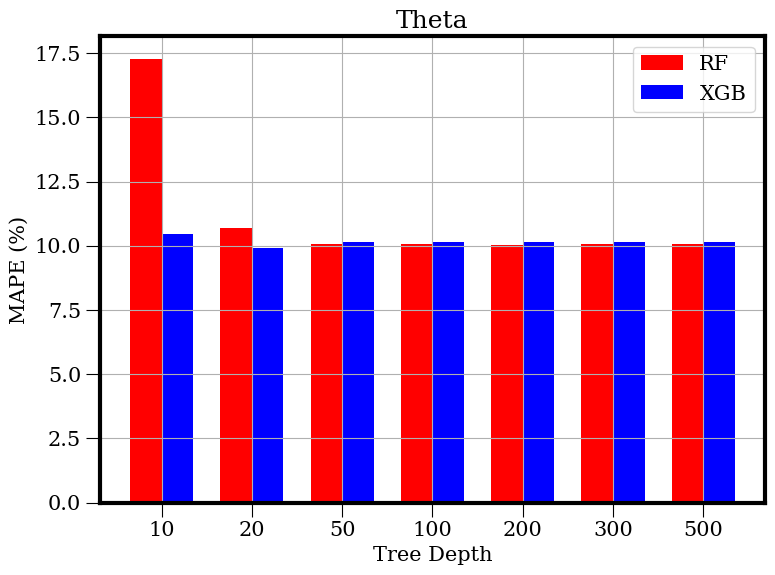

In [58]:
#performance in terms of MAPE at different tree depths
depths = max_depth_values
rf_mape = rf_mape_eval
xgb_mape = xgb_mape_eval

x = np.arange(len(depths))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rf_bars = ax.bar(x - width/2, rf_mape, width, label='RF', color='red')
xgb_bars = ax.bar(x + width/2, xgb_mape, width, label='XGB', color='blue')

ax.set_xlabel('Tree Depth')
ax.set_ylabel('MAPE (%)')
ax.set_title('Theta')  
ax.set_xticks(x)
ax.set_xticklabels(depths)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

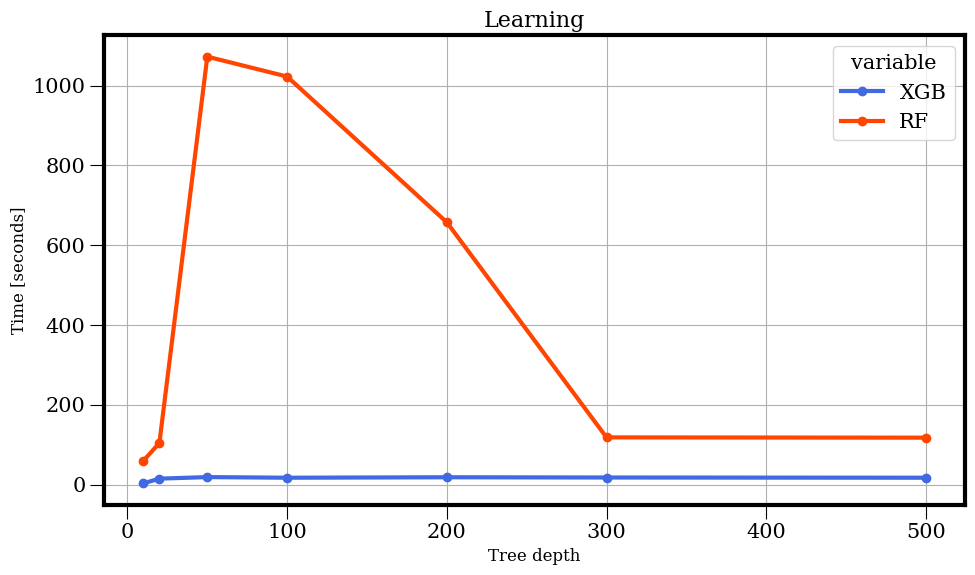

In [59]:
#plot training time
depths = max_depth_values
rf_times = rf_train_times
xgb_times = xgb_train_times

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')

plt.title('Learning', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

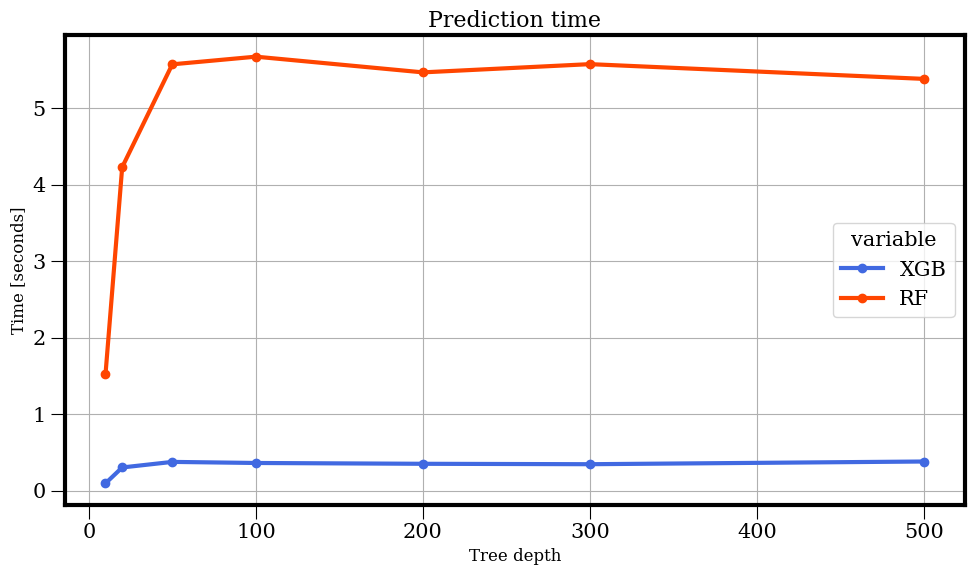

In [60]:
#plot prediction time
depths = max_depth_values
rf_times = rf_predict_times
xgb_times = xgb_predict_times

plt.figure(figsize=(10, 6))
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')
plt.title('Prediction time', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
#plot r2_scores
depths = max_depth_values

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, rf_r2_scores_eval, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, xgb_r2_scores_eval, marker='o', label='RF', color='orangered')

# Labels and title
plt.title('Polaris', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('r2_score', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

# MLP

In [9]:
# standardize the features and target variables and also reshape the target to make it suitable for neural net
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_eval_scaled = sc_X.transform(X_eval)
X_test_scaled = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train_scaled = sc_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()




In [11]:
# Define the parameter space
param_dist = {
    'hidden_layer_sizes': [(50,50), (50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000,5000]
}



In [13]:
# MLP
mlp = MLPRegressor(random_state=42)

# Randomized search with 5 fold cross-validation
random_search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_scaled, y_train_scaled)

# Best model
best_mlp = random_search.best_estimator_



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, max_iter=1000, solver=adam; total time= 2.9min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=constant, learning_rate_init=0.001, max_iter=500, solver=sgd; total time=35.7min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.001, max_iter=1000, solver=sgd; total time=68.0min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.0001, max_iter=5000, solver=sgd; total time= 2.2min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, learning_rate_init=0.0001, max_iter=5000, solver=sgd; total time= 2.1min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=5000, solver=adam; total time= 4.4min
[CV] END activ

In [14]:
print("Best parameters found:\n", best_mlp)

Best parameters found:
 MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100),
             learning_rate_init=0.0001, max_iter=5000, random_state=42)


In [17]:
# Evaluation on evaluation set
y_eval_pred_scaled = best_mlp.predict(X_eval_scaled)
y_eval_pred = sc_y.inverse_transform(y_eval_pred_scaled.reshape(-1, 1)).ravel()

r2_eval = r2_score(y_eval, y_eval_pred)
rmse_eval = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
mae_eval = mean_absolute_error(y_eval, y_eval_pred)
mape_eval = mean_absolute_percentage_error(y_eval, y_eval_pred)
print(f"  R² Score: {r2_eval:.4f}")
print(f"  RMSE    : {rmse_eval:.4f}")
print(f"  MAE     : {mae_eval:.4f}")
print(f"  MAPE    : {mape_eval:.4f}")



  R² Score: 0.6753
  RMSE    : 19.3266
  MAE     : 6.5670
  MAPE    : 218.2497


In [19]:
# Predict with best model 
y_pred_scaled =best_mlp.predict(X_test_scaled)

# Inverse transform the predictions
y_test_pred = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Evaluation on Test Set
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"  R² Score: {r2_test:.4f}")
print(f"  RMSE    : {rmse_test:.4f}")
print(f"  MAE     : {mae_test:.4f}")
print(f"  MAPE    : {mape_test:.4f}")




  R² Score: 0.6491
  RMSE    : 23.8142
  MAE     : 6.6155
  MAPE    : 218.7195


# Classification

In [76]:
#Hypeparameter search for RF classifier
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [78]:
#reshape the target class to make it suitable for MLP
y_train_class = y_train_class.values.ravel() 


In [80]:
rf_clf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_clf,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=5,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train_class, y_train_class)
# Best parameters
best_classifier_params_rf = random_search.best_params_
print("Best Hyperparameters for RF Classification:\n", best_classifier_params_rf)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=10.9min
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=19.8min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=52.8min
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=10.9min
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=19.9min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=52.7min
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50

In [81]:
#Train with hyperparameters from random search 
#best_params = random_search.best_params_
if 'max_depth' in best_classifier_params_rf:
    del best_classifier_params_rf['max_depth']
    
# List of max_depth values to try
max_depth_values = [10, 20, 50, 100, 300, 500]

# Containers to store results
rf_train_times = []
rf_predict_times = []
rf_bal_acc_train = []
rf_bal_acc_eval = []

# Loop over different max_depth values
for depth in max_depth_values:
    print(f"\nTraining RandomForestClassifier with tree depth = {depth}")
    params = best_classifier_params_rf.copy()
    params['max_depth'] = depth
    rf = RandomForestClassifier(**params)

    # Train the model on training set
    start_train = time.time()
    rf.fit(X_train_class, y_train_class)
    end_train = time.time()
    train_duration = end_train - start_train
    rf_train_times.append(train_duration)
    print(f"Training time: {train_duration:.2f} seconds")

    # Predict on evaluation set
    start_test = time.time()
    y_eval_pred = rf.predict(X_eval_class)
    end_test = time.time()
    predict_duration = end_test - start_test
    rf_predict_times.append(predict_duration)
    print(f"Prediction time: {predict_duration:.2f} seconds")

    # Evaluate performance on evaluation data
    bal_acc = balanced_accuracy_score(y_eval_class, y_eval_pred)
    rf_bal_acc_eval.append(bal_acc)
    print(f"  Evaluation Balanced Accuracy: {bal_acc:.4f}")
    

   



Training RandomForestClassifier with tree depth = 10
Training time: 46.21 seconds
Prediction time: 1.06 seconds
  Evaluation Balanced Accuracy: 0.2136

Training RandomForestClassifier with tree depth = 20
Training time: 74.56 seconds
Prediction time: 2.77 seconds
  Evaluation Balanced Accuracy: 0.4754

Training RandomForestClassifier with tree depth = 50
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=37.1min
Training time: 79.58 seconds
Prediction time: 3.46 seconds
  Evaluation Balanced Accuracy: 0.5204

Training RandomForestClassifier with tree depth = 100
Training time: 79.82 seconds
Prediction time: 3.16 seconds
  Evaluation Balanced Accuracy: 0.5183

Training RandomForestClassifier with tree depth = 300
Training time: 78.70 seconds
Prediction time: 3.20 seconds
  Evaluation Balanced Accuracy: 0.5183

Training RandomForestClassifier with tree depth = 500
Training time: 77.66 seconds
Prediction tim

In [82]:
# Select the best depth based on evaluation balanced accuracy
best_depth_index = np.argmax(rf_bal_acc_eval)
optimal_depth = max_depth_values[best_depth_index]
print(f"\nBest max_depth based on evaluation data: {optimal_depth}")

# Train final model with best depth
print("\nRetraining final model with best max_depth and evaluating on test data...")
best_classifier_params_rf['max_depth'] = optimal_depth
rf_final_class_model = RandomForestClassifier(**best_classifier_params_rf)
rf_final_class_model.fit(X_train_class, y_train_class)

# Predict on test set
y_test_pred = rf_final_class_model.predict(X_test_class)
rf_bal_acc_test = balanced_accuracy_score(y_test_class, y_test_pred)
print("\nFinal Test Set Evaluation:")
print(f"  Test Balanced Accuracy: {rf_bal_acc_test:.4f}")



Best max_depth based on evaluation data: 50

Retraining final model with best max_depth and evaluating on test data...

Final Test Set Evaluation:
  Test Balanced Accuracy: 0.5260


# XGB

In [86]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
    
}

In [88]:
# Randomized search
xgb = XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, 
                                   scoring='balanced_accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_class, y_train_class)

# Get best hyperparameters
best_classifier_params_xgb = random_search.best_params_
best_classifier_params_xgb

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'subsample': 1.0,
 'reg_lambda': 2,
 'reg_alpha': 1,
 'n_estimators': 200,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [89]:
if 'max_depth' in best_classifier_params_xgb:
    del best_classifier_params_xgb['max_depth']

# Tree depths to test
max_depth_values = [10, 20, 50, 100, 300, 500]

# Containers for results
xgb_train_times = []
xgb_predict_times = []
xgb_bal_acc_train = []
xgb_bal_acc_eval = []

# Training and evaluation loop
for depth in max_depth_values:
    print(f"\nTraining XGBClassifier with tree depth = {depth}")
    params = best_classifier_params_xgb.copy()
    params['max_depth'] = depth

    clf = XGBClassifier(**params)

    # Train on training data
    start_train = time.time()
    clf.fit(X_train_class, y_train_class)
    end_train = time.time()
    train_time = end_train - start_train
    xgb_train_times.append(train_time)
    print(f"Training time: {train_time:.2f} seconds")

    # Predict on evaluation set
    start_test = time.time()
    y_eval_pred = clf.predict(X_eval_class)
    end_test = time.time()
    predict_time = end_test - start_test
    xgb_predict_times.append(predict_time)
    print(f"Prediction time: {predict_time:.2f} seconds")
    
    # Evaluate performance on evaluation data
    bal_acc = balanced_accuracy_score(y_eval_class, y_eval_pred)
    xgb_bal_acc_eval.append(bal_acc)
    print("Test Set Evaluation:")
    print(f"  Balanced Accuracy: {bal_acc:.4f}")

    


Training XGBClassifier with tree depth = 10
Training time: 17.21 seconds
Prediction time: 0.80 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.4936

Training XGBClassifier with tree depth = 20
Training time: 35.29 seconds
Prediction time: 3.21 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.5343

Training XGBClassifier with tree depth = 50
Training time: 37.42 seconds
Prediction time: 3.80 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.5331

Training XGBClassifier with tree depth = 100
Training time: 38.42 seconds
Prediction time: 4.05 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.5338

Training XGBClassifier with tree depth = 300
Training time: 39.57 seconds
Prediction time: 3.90 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.5338

Training XGBClassifier with tree depth = 500
Training time: 41.96 seconds
Prediction time: 3.76 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.5338


In [90]:
# Select the best depth based on evaluation balanced accuracy
best_depth_index = np.argmax(xgb_bal_acc_eval)
optimal_depth = max_depth_values[best_depth_index]
print(f"\nBest max_depth based on evaluation data: {optimal_depth}")

# Train final model with best depth
print("\nRetraining final XGB model with best max_depth and evaluating on test data...")
best_classifier_params_xgb['max_depth'] = optimal_depth
xgb_final_class_model = XGBClassifier(**params)
xgb_final_class_model.fit(X_train_class, y_train_class)

# Predict on test set
y_test_pred = xgb_final_class_model.predict(X_test_class)
xgb_bal_acc_test = balanced_accuracy_score(y_test_class, y_test_pred)
print("\nFinal Test Set Evaluation:")
print(f"  Test Balanced Accuracy: {rf_bal_acc_test:.4f}")


Best max_depth based on evaluation data: 20

Retraining final XGB model with best max_depth and evaluating on test data...

Final Test Set Evaluation:
  Test Balanced Accuracy: 0.5260


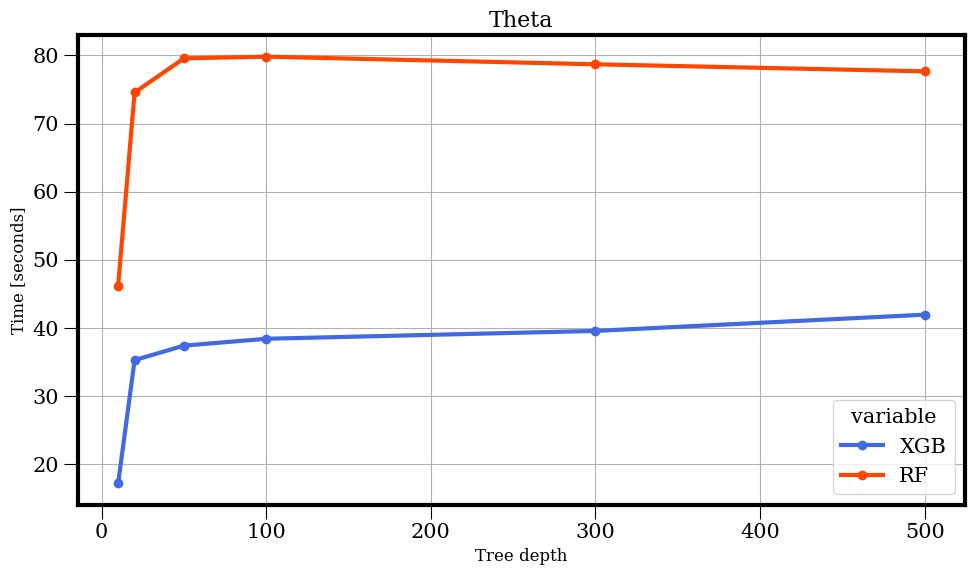

In [94]:
#plot training time
depths = max_depth_values
rf_times = rf_train_times
xgb_times = xgb_train_times

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')

# Labels and title
plt.title('Theta', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

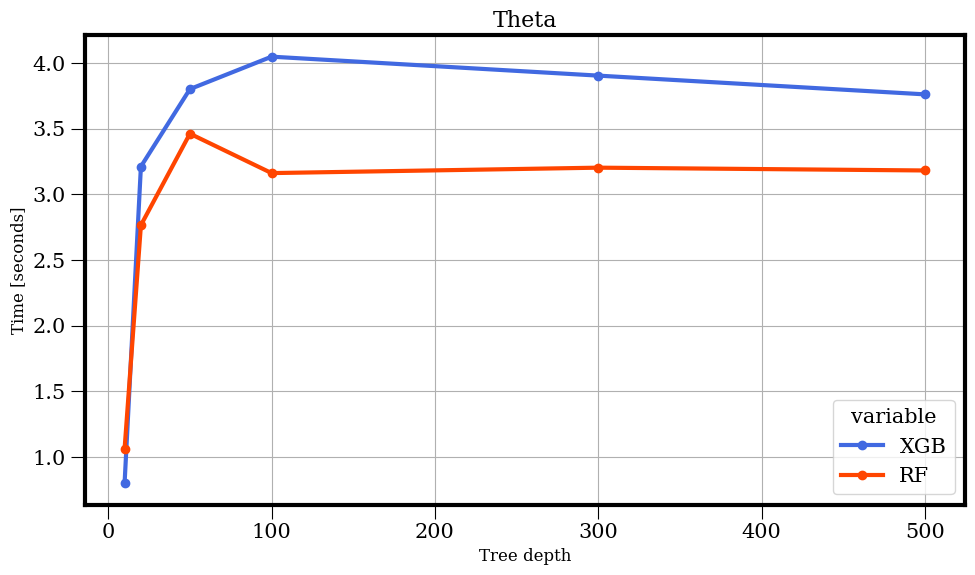

In [96]:
#plot prediction time
depths = max_depth_values
rf_times = rf_predict_times
xgb_times = xgb_predict_times

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')

# Labels and title
plt.title('Theta', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

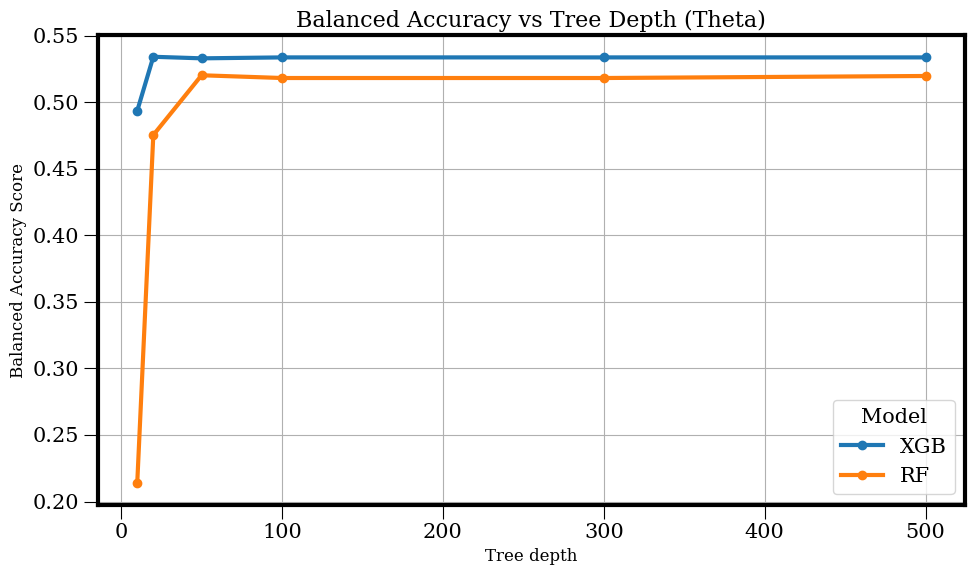

In [98]:
# Plot balanced accuracy
depths = max_depth_values

plt.figure(figsize=(10, 6))
plt.plot(depths, xgb_bal_acc_eval, marker='o', label='XGB')
plt.plot(depths, rf_bal_acc_eval, marker='o', label='RF')
plt.title('Balanced Accuracy vs Tree Depth (Theta)', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Balanced Accuracy Score', fontsize=12)
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()

plt.show()


# MLP

In [62]:
# Standardize input features for classification(important for MLPs)
sc_X = StandardScaler()
X_train_class_scaled = sc_X.fit_transform(X_train_class)
X_eval_class_scaled = sc_X.transform(X_eval_class)
X_test_class_scaled = sc_X.transform(X_test_class)

#reshape the target
y_train_class = y_train_class.values.ravel() 

In [47]:
# Define hyperparameter search space
 'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'max_iter': [500,1000,2000,5000]
}

In [49]:
#Setup MLPClassifier and hyperparameter tuning
mlp_clf = MLPClassifier(random_state=42)

random_search_clf = RandomizedSearchCV(
    mlp_clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search_clf.fit(X_train_class_scaled, y_train_class)

# Get the best estimator
best_clf = random_search_clf.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_clf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END activation=tanh, hidden_layer_sizes=(10, 10), learning_rate_init=0.1, max_iter=1000, solver=sgd; total time=  10.7s
[CV] END activation=relu, hidden_layer_sizes=(50, 25), learning_rate_init=0.01, max_iter=5000, solver=adam; total time=  36.4s
[CV] END activation=tanh, hidden_layer_sizes=(10, 10), learning_rate_init=0.1, max_iter=5000, solver=adam; total time=   3.3s
[CV] END activation=tanh, hidden_layer_sizes=(10, 10), learning_rate_init=0.1, max_iter=5000, solver=adam; total time=   3.2s
[CV] END activation=relu, hidden_layer_sizes=(10, 10), learning_rate_init=0.001, max_iter=5000, solver=adam; total time=  14.9s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=5000, solver=sgd; total time= 2.0min
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.005, max_iter=1000, solver=adam; total time=  19.9s
[CV] END activation=relu, hidden_layer_sizes=(100,), lea

In [51]:
# Evaluate on evaluation data
y_eval_pred = best_clf.predict(X_eval_class_scaled)
acc_eval = balanced_accuracy_score(y_eval_class, y_eval_pred)
print(f"Evaluation Set Balanced Accuracy: {acc_eval:.4f}")


Evaluation Set Balanced Accuracy: 0.2726


In [53]:
# Evaluate on test data
y_test_pred = best_clf.predict(X_test_class_scaled)
acc_test = balanced_accuracy_score(y_test_class, y_test_pred)
print(f"Test Set Balanced Accuracy: {acc_test:.4f}")

Test Set Balanced Accuracy: 0.2718
